In [494]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from sklearn.model_selection import StratifiedKFold

data = pd.read_csv('winequality-red.csv',sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


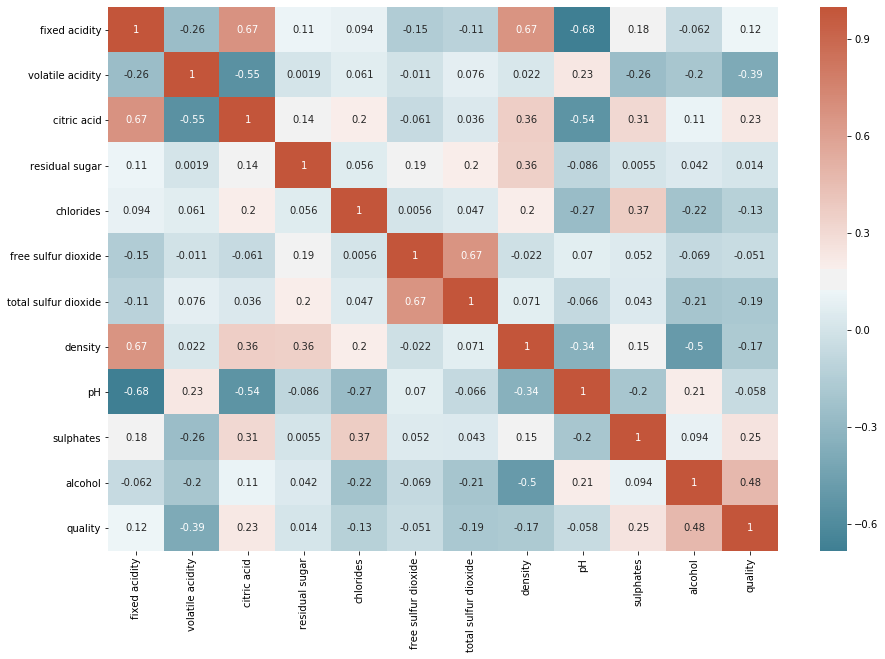

In [495]:
corr = data.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

우선, quality와 관련있는 변수들의 상관관계를 파악하기 위해 plot를 만들었다.
quality와 관련도가 높은 데이터는 alcohol, sulphates, citric acid이다.

데이터를 분류하기 위해서 quality가 7 이상인 데이터들은 모두 1, 그렇지 않은 데이터들은 0으로 바꾸어 주었다.
target 데이터의 분포는 다음과 같다

In [496]:
data['quality1'] = [1 if x >= 7 else 0 for x in data['quality']]
data.quality1.value_counts()

0    1382
1     217
Name: quality1, dtype: int64

In [497]:
feature = data.drop(['quality','quality1'],axis=1)
quality = data['quality1']
feature.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [498]:
X_train, X_test, y_train, y_test = train_test_split(feature,quality,stratify=quality,test_size=0.2,random_state=1)
y_train.value_counts()

0    1105
1     174
Name: quality1, dtype: int64

## 각각의 알고리즘을 사용했을 때 나오는 정확도

In [499]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5, shuffle=True, random_state=0)


#### SVM accuracy

In [500]:
model = SVC()
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold)
model.fit(X_train,y_train)

predY = model.predict(X_test)
print('SVM accuracy: ', scores.mean())

SVM accuracy:  0.8639460784313725


#### Naive Bayes accuracy

In [501]:
model = GaussianNB()
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold)
model.fit(X_train,y_train)

predY = model.predict(X_test)
print('Naive Bayes accuracy: ', scores.mean())

Naive Bayes accuracy:  0.8279993872549019


#### 19-NN accuracy

In [502]:
model = KNeighborsClassifier()
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold)
model.fit(X_train,y_train)

predY = model.predict(X_test)
print('Naive Bayes accuracy: ', scores.mean())

Naive Bayes accuracy:  0.8483057598039215


#### Decision Tree accuracy

In [503]:
model = DecisionTreeClassifier()
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold)
model.fit(X_train,y_train)

predY = model.predict(X_test)
print('Decision Tree accuracy: ', scores.mean())

Decision Tree accuracy:  0.8616145833333334


위 그래프를 통해 
KNN > SVM > Decision Tree > Navie Bayes  순으로 ROC가 크다는 것을 확인할 수 있다.

## 각각의 알고리즘을 사용했을 때 나오는 ROC curve
ROC curve는 보통 binary classification, medical application에서 주로 쓰이는 성능 척도로, accuracy의 단점을 보안하는 성능 척도이다.
<p> accuracy는 클래스별 분포가 같을 때만 사용하는데, 
<p> quality가 좋은 와인이 217병, 좋지 않은 와인이 1382병 이므로 클래스별 분포가 극심해 accuracy보다는 ROC curve를 통해 성능을 측정하는 것이 더 바람직하다.

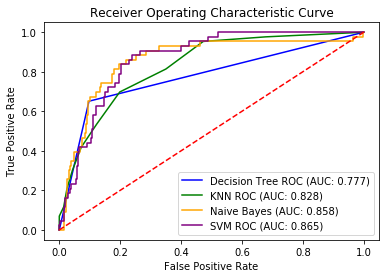

In [504]:
def plot_roc(model,color,label):
    model.fit(X_train,y_train)
    prob = model.predict_proba(X_test)
    prob = prob[:, 1]
    fper, tper, thresholds = roc_curve(y_test, prob)
    roc_score = roc_auc_score(y_test, prob)
    plt.plot(fper, tper, color=color, label='{0} (AUC: {1:.3f})'.format(label,roc_score))


# Decision Tree
model = DecisionTreeClassifier(random_state=1124)
plot_roc(model, 'blue','Decision Tree ROC')

# KNN
model = KNeighborsClassifier(n_neighbors = 19, p=2)
plot_roc(model, 'green','KNN ROC')


# Naive Bayes
model = GaussianNB()
plot_roc(model, 'orange','Naive Bayes')

# SVM
model = SVC(probability=True)
plot_roc(model, 'purple','SVM ROC')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

위 그래프를 통해 
SVM > Navie Bayes > KNN > Decision Tree 순으로 ROC가 크다는 것을 확인할 수 있다.

In [505]:
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

In [506]:
def predict_accuracy(model):
    model.fit(X_train,y_train)
    prediction = cross_val_predict(model, X_train, y_train, cv=kfold)
    predY = model.predict(X_test)
    cm = confusion_matrix(y_train, prediction)
    acc = accuracy_score(y_test, predY)
    return acc,cm

# Decision Tree
model = DecisionTreeClassifier(random_state=1124)
show = predict_accuracy(model)
print('Decision Tree predict accracy: {}'.format(show[0]),'confusion matrix:',show[1],'\n',sep='\n')

# KNN
model = KNeighborsClassifier(n_neighbors = 19, p=2)
show = predict_accuracy(model)
print('KNN predict accracy: {}'.format(show[0]),'confusion matrix:',show[1],'\n',sep='\n')

# Naive Bayes
model = GaussianNB(priors=None, var_smoothing=1e-09)
show = predict_accuracy(model)
print('Naive Bayes predict accracy: {}'.format(show[0]),'confusion matrix:',show[1],'\n',sep='\n')

#SVM
model = SVC(probability=True)
show = predict_accuracy(model)
print('SVM predict accracy: {}'.format(show[0]),'confusion matrix:',show[1],'\n',sep='\n')

Decision Tree predict accracy: 0.86875
confusion matrix:
[[1010   95]
 [  87   87]]


KNN predict accracy: 0.875
confusion matrix:
[[1100    5]
 [ 168    6]]


Naive Bayes predict accracy: 0.825
confusion matrix:
[[945 160]
 [ 60 114]]


SVM predict accracy: 0.86875
confusion matrix:
[[1105    0]
 [ 174    0]]




## OverSampling
오버 샘플링은 현재 분석하고 있는 데이터와 같이 불균형한 데이터를 분석할 때, 조금 더 정확히 학습시키기 위해 사용하는 기법이다.

<p> 우선, 1: 1382, 0: 217이므로 데이터의 수가 너무 낮아지지 않게, undersampling 보다 oversampling을 사용했다. 이러한 oversampling 중에서도 여러 기법이 있어 이를 조사해 보았다.
<p> - Random OverSampling: 기존에 존재하던 클래스들을 복제해 비율 맞추기
<p> - SMOTE: 낮은 비율 클래스 데이터들의 최근접 이웃을 이용해 새로운 데이터 생성하기
<p> - Borderine SMOTE: 기존의 SMOTE와 비슷하지만, 고립된 데이터는 SMOTE를 적용시키지 않는 방법
<p> - ADASYN: 가중치를 통해 SMOTE를 적용
    
#### 이 중, SMOTE, ADASYN, Random OverSampling 기법을 사용했다.

In [507]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

y_train.value_counts()

0    1105
1     174
Name: quality1, dtype: int64

### oversampling을 했을 경우, 정확도 비교

In [508]:
#oversampling = SMOTE()
#oversampling = RandomOverSampler(sampling_strategy='minority')
'''
oversampling = ADASYN(random_state=0)
X_resampled, y_resampled = oversampling.fit_resample(X_train,y_train)
print(y_resampled.value_counts())
'''

def plot_roc_oversampler(model,color,label):
    model.fit(X_resampled,y_resampled)
    prob = model.predict_proba(X_test)
    prob = prob[:, 1]
    fper, tper, thresholds = roc_curve(y_test, prob)
    roc_score = roc_auc_score(y_test, prob)
    plt.plot(fper, tper, color=color, label='{0} (AUC: {1:.3f})'.format(label,roc_score))

def print_acc_cm(model,sampler):
    prediction = cross_val_predict(model, X_resampled, y_resampled, cv=kfold)
    predY = model.predict(X_test)

    cm = confusion_matrix(y_resampled, prediction)
    acc = accuracy_score(y_test, predY)
    print("Best oversampling techniques: {}\n predict accuracy: {}\n\n confusion_matrix\n{}".format(sampler,acc,cm)) 

#### Navie Bayes oversampling

Best oversampling techniques: RandomOverSampler
 predict accuracy: 0.7375

 confusion_matrix
[[776 329]
 [172 933]]


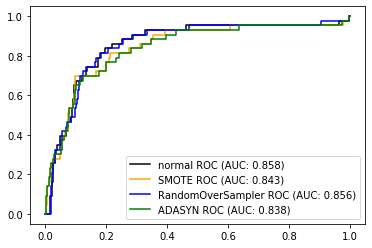

In [509]:
model = GaussianNB(priors=None, var_smoothing=1e-09)

plot_roc(model, 'black','normal ROC') 

X_resampled, y_resampled = SMOTE().fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)
plot_roc_oversampler(model, 'orange','SMOTE ROC') 

X_resampled, y_resampled = RandomOverSampler(sampling_strategy='minority').fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)
plot_roc_oversampler(model, 'blue','RandomOverSampler ROC') 
print_acc_cm(model,'RandomOverSampler')

X_resampled, y_resampled = ADASYN().fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)
plot_roc_oversampler(model, 'green','ADASYN ROC')

plt.legend()
plt.show()

In [510]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
    # var_smothing: 분산에 추가되는 모든 feature들의 가장 큰 분산의 일부
}

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_resampled, y_resampled)

best_grid = nbModel_grid.best_estimator_
prediction = cross_val_predict(best_grid, X_resampled, y_resampled, cv=10)
predY = best_grid.predict(X_resampled)

acc = accuracy_score(y_resampled,predY)
cm = confusion_matrix(y_resampled, prediction)

print("\nNaive Bayer(after GridSearchCV) with predict accuracy: {}".format(acc)) 
cm

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

Naive Bayer(after GridSearchCV) with predict accuracy: 0.7986394557823129


array([[807, 298],
       [151, 949]], dtype=int64)

### KNN oversampling

Best oversampling techniques: ADASYN
 predict accuracy: 0.759375

 confusion_matrix
[[ 825  280]
 [  29 1071]]


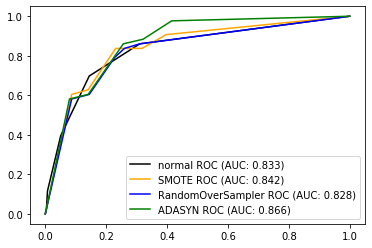

In [511]:
model = KNeighborsClassifier()

plot_roc(model, 'black','normal ROC') 

X_resampled, y_resampled = SMOTE().fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)
plot_roc_oversampler(model, 'orange','SMOTE ROC') 

X_resampled, y_resampled = RandomOverSampler(sampling_strategy='minority').fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)
plot_roc_oversampler(model, 'blue','RandomOverSampler ROC') 

X_resampled, y_resampled = ADASYN().fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)
plot_roc_oversampler(model, 'green','ADASYN ROC')
print_acc_cm(model,'ADASYN')

plt.legend()
plt.show()

{'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]}
최적의 k는 : [19]


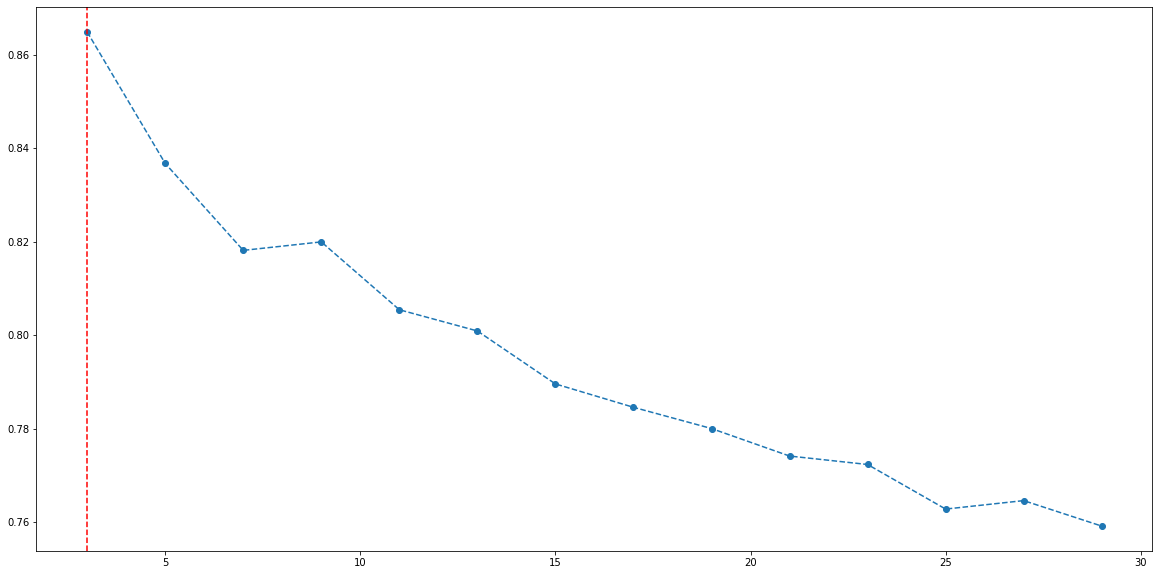

In [512]:
model = KNeighborsClassifier()
X_resampled, y_resampled = ADASYN().fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)
k_list = [i for i in range(3,31) if i%2 == 1]

param_grid = dict(n_neighbors=k_list)
print(param_grid)

grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_resampled, y_resampled)

result = pd.DataFrame(grid.cv_results_['params'])
result['mean_test_score'] = grid.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

plt.figure(figsize=(20,10))
plt.plot(k_list,result['mean_test_score'] ,marker='o', linestyle='dashed')
plt.axvline(3,color='red',linestyle='--')
print('최적의 k는 :',best_k)

In [513]:
best_grid = grid.best_estimator_
prediction = cross_val_predict(best_grid, X_resampled, y_resampled, cv=10)
predY = best_grid.predict(X_resampled)

acc = accuracy_score(y_resampled,predY)
cm = confusion_matrix(y_resampled, prediction)

print("\nNaive Bayer(after GridSearchCV) with predict accuracy: {}".format(acc)) 
cm


Naive Bayer(after GridSearchCV) with predict accuracy: 0.9414965986394558


array([[ 881,  224],
       [  74, 1026]], dtype=int64)

### Decision Tree oversampling

Best oversampling techniques: SMOTE
 predict accuracy: 0.86875

 confusion_matrix
[[ 971  134]
 [  91 1009]]


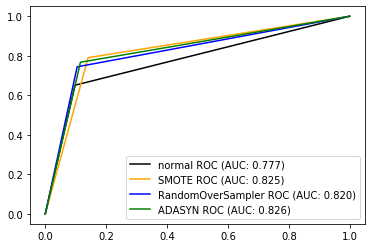

In [514]:
model = DecisionTreeClassifier(random_state=1124)

plot_roc(model, 'black','normal ROC') 

X_resampled, y_resampled = SMOTE().fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)
plot_roc_oversampler(model, 'orange','SMOTE ROC') 

X_resampled, y_resampled = RandomOverSampler(sampling_strategy='minority').fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)
plot_roc_oversampler(model, 'blue','RandomOverSampler ROC') 

X_resampled, y_resampled = ADASYN().fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)
plot_roc_oversampler(model, 'green','ADASYN ROC')
print_acc_cm(model,'SMOTE')

plt.legend()
plt.show()

In [515]:
param_grid_dt = {
    "criterion":['gini','entropy'],
    "min_samples_split":[2,3,4,5],
    'max_depth': [1,2,3,4,5]
}

model = DecisionTreeClassifier()
X_resampled, y_resampled = SMOTE().fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)

dtModel_grid = GridSearchCV(model,param_grid=param_grid_dt,cv=10,verbose=1, n_jobs=-1)
dtModel_grid.fit(X_resampled, y_resampled)

best_grid = dtModel_grid.best_estimator_
prediction = cross_val_predict(best_grid, X_resampled, y_resampled, cv=10)
predY = best_grid.predict(X_resampled)

acc = accuracy_score(y_resampled,predY)
cm = confusion_matrix(y_resampled, prediction)

print("\nNaive Bayer(after GridSearchCV) with predict accuracy: {}".format(acc)) 
cm

Fitting 10 folds for each of 40 candidates, totalling 400 fits

Naive Bayer(after GridSearchCV) with predict accuracy: 0.8755656108597285


array([[872, 233],
       [109, 996]], dtype=int64)

'max_depth': [1,2,3,4,5]에 Null을 집어넣을 경우 predict accuracy가 1.0이 나오는데, 오버피팅으로 인해 Null을 뺐다.

### SVM oversampling

Best oversampling techniques: SMOTE
 predict accuracy: 0.678125

 confusion_matrix
[[656 449]
 [237 868]]


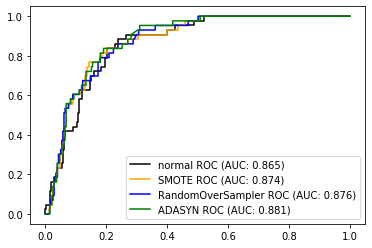

In [516]:
model = SVC(probability=True)

plot_roc(model, 'black','normal ROC') 
k
X_resampled, y_resampled = SMOTE().fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)
plot_roc_oversampler(model, 'orange','SMOTE ROC') 
print_acc_cm(model,'SMOTE')

X_resampled, y_resampled = RandomOverSampler(sampling_strategy='minority').fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)
plot_roc_oversampler(model, 'blue','RandomOverSampler ROC') 

X_resampled, y_resampled = ADASYN().fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)
plot_roc_oversampler(model, 'green','ADASYN ROC')

plt.legend()
plt.show()

In [521]:
values = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'C':values, 'gamma':values}

model = SVC(kernel='rbf')
X_resampled, y_resampled = SMOTE().fit_resample(X_train,y_train)
model.fit(X_resampled,y_resampled)

svmModel_grid = GridSearchCV(model,param_grid, cv=5,verbose=1, n_jobs=-1)
svmModel_grid.fit(X_resampled, y_resampled)

best_grid = svmModel_grid.best_estimator_
prediction = cross_val_predict(best_grid, X_resampled, y_resampled, cv=10)
predY = best_grid.predict(X_resampled)

acc = accuracy_score(y_resampled,predY)
cm = confusion_matrix(y_resampled, prediction)

print("\nNaive Bayer(after GridSearchCV) with predict accuracy: {}".format(acc)) 
cm

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Naive Bayer(after GridSearchCV) with predict accuracy: 0.9995475113122172


array([[1004,  101],
       [  31, 1074]], dtype=int64)

# 데이터간의 상관관계 파악하기

In [160]:
df_temp = data[data['quality1']==1]
df_temp.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality1
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.0
mean,8.847005,0.405530,0.376498,2.708756,0.075912,13.981567,34.889401,0.996030,3.288802,0.743456,11.518049,7.082949,1.0
std,1.999977,0.144963,0.194438,1.363026,0.028480,10.234615,32.572238,0.002201,0.154478,0.134038,0.998153,0.276443,0.0
min,4.900000,0.120000,0.000000,1.200000,0.012000,3.000000,7.000000,0.990640,2.880000,0.390000,9.200000,7.000000,1.0
25%,7.400000,0.300000,0.300000,2.000000,0.062000,6.000000,17.000000,0.994700,3.200000,0.650000,10.800000,7.000000,1.0
50%,8.700000,0.370000,0.400000,2.300000,0.073000,11.000000,27.000000,0.995720,3.270000,0.740000,11.600000,7.000000,1.0
75%,10.100000,0.490000,0.490000,2.700000,0.085000,18.000000,43.000000,0.997350,3.380000,0.820000,12.200000,7.000000,1.0
max,15.600000,0.915000,0.760000,8.900000,0.358000,54.000000,289.000000,1.003200,3.780000,1.360000,14.000000,8.000000,1.0


In [162]:
df_temp2 = data[data['quality1']==0]
df_temp2.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality1
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.0
mean,8.236831,0.547022,0.254407,2.512120,0.089281,16.172214,48.285818,0.996859,3.314616,0.644754,10.251037,5.408828,0.0
std,1.682726,0.176337,0.189665,1.415778,0.049113,10.467685,32.585604,0.001808,0.154135,0.170629,0.969664,0.601719,0.0
min,4.600000,0.160000,0.000000,0.900000,0.034000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.0
25%,7.100000,0.420000,0.082500,1.900000,0.071000,8.000000,23.000000,0.995785,3.210000,0.540000,9.500000,5.000000,0.0
50%,7.800000,0.540000,0.240000,2.200000,0.080000,14.000000,39.500000,0.996800,3.310000,0.600000,10.000000,5.000000,0.0
75%,9.100000,0.650000,0.400000,2.600000,0.091000,22.000000,65.000000,0.997900,3.410000,0.700000,10.900000,6.000000,0.0
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,165.000000,1.003690,4.010000,2.000000,14.900000,6.000000,0.0
